In [405]:
import matplotlib.pyplot as plt
import geopandas as gpd
import requests
import json
import osm2geojson
import contextily as ctx
import shapely
import pyproj
import numpy as np
from os import environ
environ["PROJ_LIB"] = "/home/debian/miniconda3/envs/geo/lib/python3.8/site-packages/rasterio/proj_data"

In [242]:
def get_osm_data(lat, lng):
    # print(lat, lng)
    overpass_url = "http://overpass-api.de/api/interpreter"
    # 60.148809, 24.916404 helsinki
    # 51.888806, 4.429777 amsterdam
    # 60.18636636163917 24.83902037143707 otaniemi              
    overpass_query = """
    [out:json][timeout:25];
    nwr[~"^(natural|area|pier)$"~"."](around:200,""" + f'{lat},{lng}' + """);
    out geom;
    """
    response = requests.get(overpass_url, 
                            params={'data': overpass_query})
    data = response.json()
    return osm2geojson.json2geojson(data)


51.88692186814117 4.2840078206463685
{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'type': 'relation', 'id': 13070155, 'tags': {'natural': 'water', 'type': 'multipolygon', 'water': 'harbour', 'wikidata': 'Q1892864'}}, 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[4.2820895, 51.8854948], [4.2821179, 51.8855161], [4.2821169, 51.8855568], [4.2817098, 51.8863193], [4.2816892, 51.8864101], [4.2812849, 51.8871662], [4.2809496, 51.8877866], [4.2809483, 51.8878372], [4.2811902, 51.8881381], [4.2812341, 51.8881629], [4.2817641, 51.8882718], [4.2818922, 51.8882907], [4.282464, 51.8884051], [4.2829264, 51.8884859], [4.2830127, 51.8884979], [4.2835169, 51.8885903], [4.2835746, 51.8885908], [4.283635, 51.8885849], [4.2837803, 51.888549], [4.2840286, 51.8884799], [4.2841586, 51.888421], [4.2844723, 51.8878279], [4.284954, 51.8869035], [4.2850198, 51.8867906], [4.2851846, 51.8864885], [4.2855671, 51.8857645], [4.2855888, 51.8857369], [4.2820895, 51.8854948]]]

<AxesSubplot:>

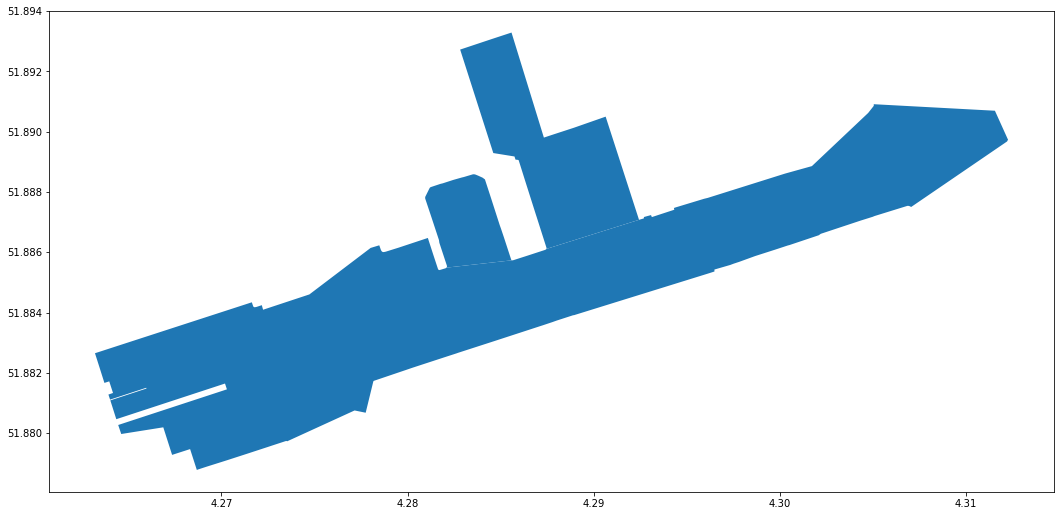

In [241]:
geojson = get_osm_data(51.88692186814117, 4.2840078206463685)
print(geojson)
gdf = gpd.GeoDataFrame.from_features(geojson)
gdf.crs = 'epsg:4326'
f, ax = plt.subplots(1, figsize=(18, 18))
gdf.plot(ax=ax)

#no_ferry = gdf[gdf["tags"]][gdf["tags"].apply(lambda x: "ferry" not in x)]
#no_ferry.plot()

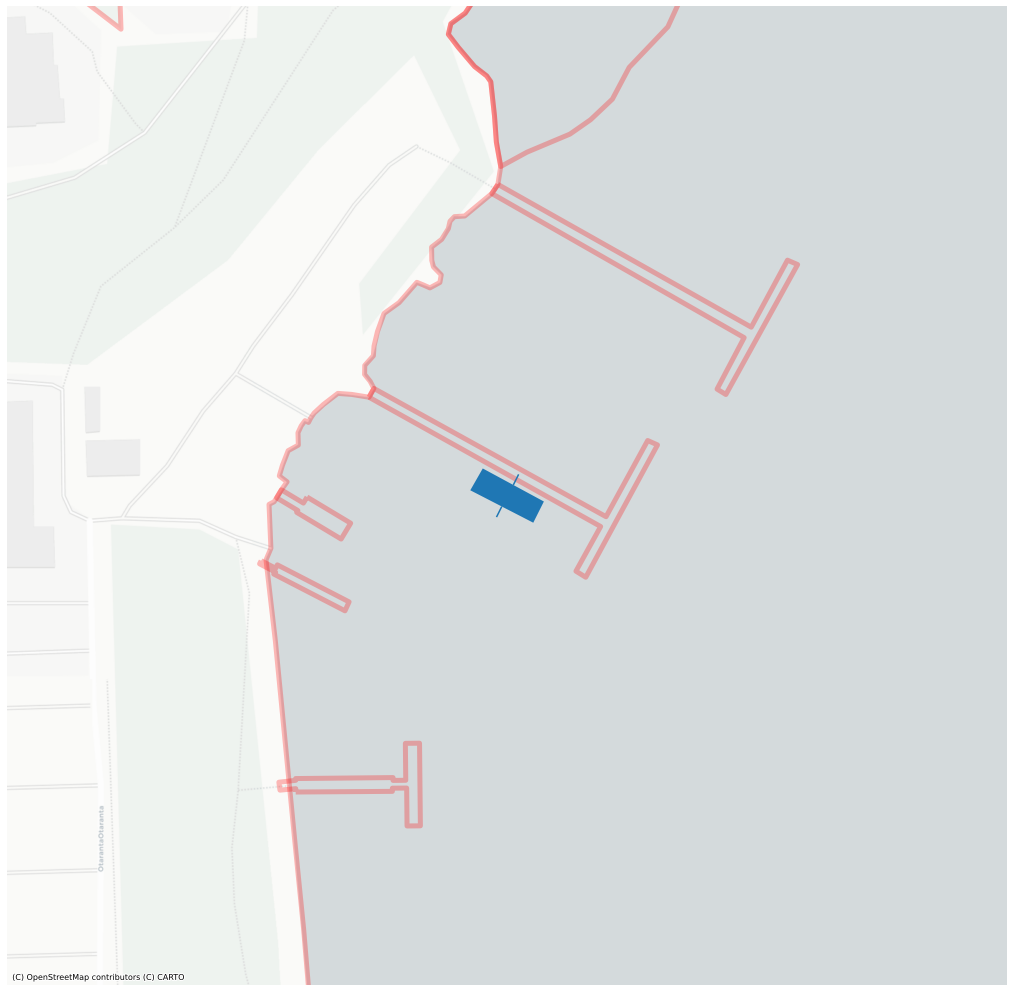

In [428]:
polygons = gpd.read_file("test-data.geojson")
#for index, geom in polygons.head(5).iterrows():
def plot_test(index):
    f, ax = plt.subplots(1, figsize=(18, 18))
    row = polygons.iloc[[index]]
    geom = row.geometry
    # polygon edges as linestrings
    i = 0
    points = geom.iloc[0].exterior.coords
    uniq_points = list(points)
    edges = []
    for i in range(len(uniq_points) - 1):
        ls = shapely.geometry.LineString([uniq_points[i], uniq_points[i+1]])
        edges.append(ls)
    edges.sort(key=lambda x: x.length, reverse=True)
    # long edges are now at indexes 0 and 1

    def get_normal(i):

        normal_starting_point = np.array(edges[i].interpolate(0.5, normalized=True).coords[0])
        dx = edges[3].coords[0][0] - edges[3].coords[1][0]
        dy = edges[3].coords[0][1] - edges[3].coords[1][1]
        # smaller edge is guaranteed to be at smaller
        diff_vec = np.array([dx, dy]) / 2
        try1 = normal_starting_point + diff_vec
        try2 = normal_starting_point - diff_vec
        outpointing_vector_end = try1
        if (row.intersects(shapely.geometry.Point(try1)).all()):
            outpointing_vector_end = try2
        return shapely.geometry.LineString([normal_starting_point, outpointing_vector_end])

    n1 = get_normal(0)
    n2 = get_normal(1)
    t = gpd.GeoDataFrame.from_records([{"geometry": n1}, {"geometry": n2}])
    t.crs = "EPSG:4326"
    t = t.to_crs(3857)
    t.plot(ax=ax)

    #for i in range(100):

    #return

    # plotting
    gs = gpd.GeoSeries(geom, crs=4326)
    gs = gs.to_crs(3857)
    buffer = gs.geometry.buffer(200)
    buffer.plot(alpha=0, ax=ax)
    centroid_4326 = gs.centroid.to_crs(4326)
    osm_gdf = gpd.GeoDataFrame.from_features(
        get_osm_data(float(centroid_4326.y), float(centroid_4326.x))
    )
    osm_gdf.crs = 'epsg:4326'
    ctx.add_basemap(
        ax,
        source=ctx.providers.CartoDB.Positron
    )
    plt.autoscale(False)
    osm_intersection = gpd.clip(osm_gdf, buffer.buffer(200).to_crs(4326).geometry).to_crs(3857)
    osm_intersection.plot(ax=ax, facecolor="#0000", edgecolor="#f004", linewidth=5)
    gs.plot(ax = ax)
    ax.set_axis_off()
plot_test(0)

In [285]:
plot_test(1)
plot_test(2)
plot_test(3)

KeyError: 0